# Minimum Enclosing Ball for Anomaly Detection 

Francesco Sartori, Matteo Pernini, Irene Caria, Marco Furlan

##Libraries

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
from matplotlib import pyplot as plt

#Away-step Frank Wolfe Algorithm

In [ ]:
def AFW_plot(x_0,A,eps,max_it):
  '''Away-steps Frank-Wolfe. Output includes lists for plotting purposes.
  x_0 is a vector in A.
  A is a matrix whose rows are the coordinates of the edges of the polytope.
  eps is the threshold.
  max_it is the maximum number of iterations.
  '''

  plot_iterations = [] # plot
  plot_gap = [] # plot

  def find_row(v, A):
    '''return index of vector v as row of A'''
    for i in range(A.shape[0]):
      row = A[i]
      if np.array_equal(v, row):
        return i
    raise ValueError('v not found in A!')

  # check if x_0 is in A
  i = find_row(x_0, A)

  S = np.array([x_0])
  x = x_0
  alpha = np.zeros(A.shape[0])
  alpha[i] = 1

  for t in range(max_it):
    plot_iterations.append(t) # plot
    s = A[np.argmin(grad_f(x) @ A.T)]
    d_FW = s-x # FW direction
    v = S[np.argmax(grad_f(x) @ S.T)]
    d_A = x-v # away direction
  
    g_FW = -grad_f(x) @ d_FW
    plot_gap.append(g_FW) # plot
    
    if g_FW <= eps: # if FW gap small enough, return
      break
    if g_FW >= -grad_f(x) @ d_A: # choose FW direction
      step = 'FW'
      d = d_FW
      gamma_max = 1
    else: # choose away direction
      step = 'A'
      d = d_A
      i = find_row(v,A)
      gamma_max = alpha[i]/(1-alpha[i])
    
    #line search
    gamma_int = np.linspace(0, gamma_max, num=1000)
    gamma = gamma_int[np.argmin([f(x+gam*d) for gam in gamma_int])]

    #update x, S, alpha
    x = x + gamma*d    
    if step == 'FW':
      if gamma == 1:
        S = np.array([s])
      else:
        S = np.vstack([S,s])
      i = find_row(s,A)
      alpha = (1-gamma)*alpha
      alpha[i] = alpha[i] + gamma
    if step == 'A':
      i = find_row(v,S)
      if gamma == gamma_max:
        S = np.delete(S,i, axis = 0)
      alpha = (1+gamma)*alpha
      alpha[i] = alpha[i] - gamma

  return x, plot_iterations, plot_gap

#Pairwise Frank Wolfe Algorithm

In [ ]:
def PFW_plot(x_0,A,eps,max_it):
  '''Pairwise Frank-Wolfe. Output includes lists for plotting purposes.
  x_0 is a vector in A.
  A is a matrix whose rows are the coordinates of the edges of the polytope.
  eps is the threshold.
  max_it is the maximum number of iterations.
  '''

  plot_iterations = [] # plot
  plot_gap = [] # plot

  def find_row(v, A):
    '''return index of vector v as row of A'''
    for i in range(A.shape[0]):
      row = A[i]
      if np.array_equal(v, row):
        return i
    raise ValueError('v not found in A!')

  # check if x_0 is in A
  i = find_row(x_0, A)

  S = np.array([x_0])
  x = x_0
  alpha = np.zeros(A.shape[0])
  alpha[i] = 1

  for t in range(max_it):
    plot_iterations.append(t) # plot
    s = A[np.argmin(grad_f(x) @ A.T)]
    d_FW = s-x # FW direction
    v = S[np.argmax(grad_f(x) @ S.T)]
    d_A = x-v # away direction
  
    g_FW = -grad_f(x) @ d_FW
    plot_gap.append(g_FW) # plot
    
    if g_FW <= eps: # if FW gap small enough, return
      break
    
    d = s-v
    i = find_row(v,A)
    gamma_max = alpha[i]
    
    #line search
    gamma_int = np.linspace(0, gamma_max, num=1000)
    gamma = gamma_int[np.argmin([f(x+gam*d) for gam in gamma_int])]

    #update x, S, alpha
    x = x + gamma*d

    alpha[i] = alpha[i] - gamma # recall i = find_row(v,A)
    j = find_row(s,A)
    alpha[j] = alpha[j] + gamma

    if alpha[i] == 0:
      i = find_row(v,S)
      S = np.delete(S,i, axis = 0)
    if alpha[j] > 0:
      S = np.vstack([S,s])
    
  return x, plot_iterations, plot_gap

#Test for the two FW variants

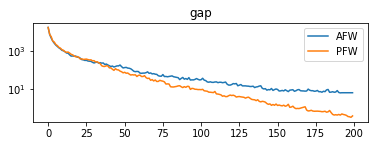

In [ ]:
np.random.seed(54)
A = np.random.rand(200,500)
x_star = np.concatenate([np.ones(25),-np.ones(25),np.zeros(450)])
x_star = x_star + np.random.rand(500)*0.1
b = A @ x_star

def f(x):
  return np.linalg.norm(A @ x - b)**2

def grad_f(x):
  return 2 * A.T @ (A @ x - b)

n = 500
positive_vertices = np.array([[int(i==j)*20 for i in range(n)] for j in range(n)])
negative_vertices = np.array([[-int(i==j)*20 for i in range(n)] for j in range(n)])
A_cal = np.concatenate([positive_vertices,negative_vertices])

x, plot_iterations_AFW, plot_gap_AFW = PFW_plot(A_cal[0,:],A_cal,0.01,200)
x, plot_iterations_PFW, plot_gap_PFW = AFW_plot(A_cal[0,:],A_cal,0.01,200)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(plot_iterations_PFW, plot_gap_PFW)
line, = ax.plot(plot_iterations_AFW, plot_gap_AFW)
ax.set_yscale('log')
plt.title('gap')
plt.legend(['AFW','PFW'])
plt.show()

#First (1 + ϵ)-approximation to MEB algorithm

In [ ]:
def phi(u, A):
  A_n=[np.dot(a,a) for a in A]
  W=sum([u[i]*A[i] for i in range(len(u))])
  return np.dot(A_n, u) - np.dot(W,W)

In [ ]:
def first_MEB(A, eps):
  '''
  The first algorithm that computes a (1+eps)-approximation to MEB(A)
  Input: set of atoms A and epsilon
  Output: center, set Chi, u, radius + annulus, radius, iterations
  '''
  alpha = np.argmax([np.linalg.norm(a - A[0])**2 for a in A])     # furthest point from A[0]
  beta = np.argmax([np.linalg.norm(a - A[alpha])**2 for a in A])  # furthest point from A[alpha]
  u = np.zeros(A.shape[0])
  u[alpha] = 1/2
  u[beta] = 1/2
  chi = {alpha, beta}   # core set
  c = np.dot(u,A)       # initial center
  gamma = phi(u, A)     # squared radius
  kappa = np.argmax([np.linalg.norm(a - c)**2 for a in A])        # furthest point from the center
  delta = (np.linalg.norm(A[kappa] - c)**2/gamma) - 1             # approximation level    
  k = 0                 # iteration
  while delta > (1+eps)**2 -1 :
    lamb = delta / (2*(1+delta))    # update parameter
    k = k+1
    u = (1-lamb)*u
    u[kappa] += lamb
    c = (1-lamb)*c + lamb*A[kappa]  # center
    chi.add(kappa)
    gamma = phi(u, A)
    kappa = np.argmax([np.linalg.norm(a - c)**2 for a in A])
    delta = (np.linalg.norm(A[kappa] - c)**2/gamma) - 1
  return [c,[A[i] for i in chi],u,np.sqrt((1+delta)*gamma),np.sqrt(gamma),k]

#Second (1 + ϵ)-approximation to MEB algorithm

In [ ]:
def second_MEB(A, eps):
  '''
  The second algorithm that computes a (1+eps)-approximation to MEB(A)
  Input: set of atoms A and epsilon
  Output: center, set Chi, u, radius + annulus, radius, iterations
  '''
  alpha = np.argmax([np.linalg.norm(a - A[0])**2 for a in A])      # furthest point from A[0]
  beta = np.argmax([np.linalg.norm(a - A[alpha])**2 for a in A])   # furthest point from A[alpha]
  u = np.zeros(A.shape[0])
  u[alpha] = 1/2
  u[beta] = 1/2
  chi = np.ones(A.shape)*np.inf   # core set
  chi[alpha] = A[alpha]
  chi[beta] = A[beta]
  c = np.dot(u,A)                 # initial center
  gamma = phi(u, A)               # squared radius
  kappa = np.argmax([np.linalg.norm(a - c)**2 for a in A])   # furthest point from the center
  csi = np.argmin([np.linalg.norm(a - c)**2 for a in chi])   # nearest point to the center
  delta_plus = (np.linalg.norm(A[kappa] - c)**2/gamma) - 1   
  delta_minus = 1 - (np.linalg.norm(A[csi] - c)**2/gamma)
  delta = np.max([delta_plus, delta_minus])                  # approximation level
  k = 0     # iteration
  while delta > (1+eps)**2 -1 :
    if delta > delta_minus:           # FW like step
      lamb = delta / (2*(1+delta))    # update parameter
      k = k+1
      u = (1-lamb)*u
      u[kappa] += lamb
      c = (1-lamb)*c + lamb*A[kappa]  # center
      chi[kappa] = A[kappa]
    else:                             # Away FW like step
      lamb = np.min([delta_minus/(2*(1-delta_minus)), u[csi]/(1-u[csi])])
      if lamb ==  u[csi]/(1-u[csi]):
        chi[csi] = np.ones(A.shape[1])*np.inf
      k = k+1
      u = (1+lamb)*u
      u[csi] -= lamb
      c = (1+lamb)*c - lamb*A[csi]
    # updates
    gamma = phi(u, A)
    kappa = np.argmax([np.linalg.norm(a - c)**2 for a in A])
    csi = np.argmin([np.linalg.norm(a - c)**2 for a in chi])
    delta_plus = (np.linalg.norm(A[kappa] - c)**2/gamma) - 1
    delta_minus = 1 - (np.linalg.norm(A[csi] - c)**2/gamma)
    delta = np.max([delta_plus, delta_minus])
  return [c,[row for row in chi if np.inf not in row],u,np.sqrt((1+delta)*gamma),np.sqrt(gamma),k]

#Datasets for the Minimum Enclosing Ball problem

In [ ]:
'''
Import Heart Disease dataset from Hungarian Institute of Cardiology

Number of instances : 261
Number of attributes : 10
'''
data1 = open("reprocessed.hungarian.data", "r").read()

data2 = data1.split('\n')
data3 = []
for row in data2:
  data3.append(row.split(' '))

data4 = []
for row in data3:
  if '' in row: # eliminate rows with null values
    continue
  data4.append(list(map(lambda x: float(x), row)))

# we deicided to rescale our data
scaler = MinMaxScaler()
data5 = [row[0:-4] for row in data4]

for i in range(len(data5)):
  data5[i].append(data4[i][-1])
data7 = [row for row in data5 if -9 not in row]  # remove the missing values (denoted with -9)
data8 = [row[0:-1] for row in data7]
data6=scaler.fit_transform(data8)
data_heart = np.array(data6)

label_heart = np.array([row[-1] for row in data7])


print(f'This is the Heart disease dataset: \n {data_heart} \n')
print(f'This is the Heart disease label: \n {label_heart}')

This is the Heart disease dataset: 
 [[0.32432432 1.         0.33333333 ... 0.83333333 0.         0.        ]
 [0.56756757 0.         0.66666667 ... 0.68518519 0.         0.2       ]
 [0.24324324 1.         0.33333333 ... 0.14814815 0.         0.        ]
 ...
 [0.54054054 1.         0.66666667 ... 0.51851852 0.         0.        ]
 [0.51351351 0.         0.33333333 ... 0.49074074 0.         0.2       ]
 [0.67567568 1.         1.         ... 0.61111111 0.         0.        ]] 

This is the Heart disease label: 
 [0. 1. 0. 3. 0. 0. 0. 1. 0. 0. 3. 0. 3. 0. 0. 1. 0. 1. 1. 0. 0. 0. 3. 0.
 0. 0. 0. 0. 3. 1. 3. 0. 0. 1. 0. 0. 0. 4. 0. 0. 3. 0. 0. 0. 0. 1. 2. 4.
 0. 0. 0. 0. 1. 1. 0. 3. 0. 0. 1. 0. 0. 0. 0. 3. 0. 1. 0. 2. 0. 2. 2. 0.
 0. 1. 0. 0. 1. 0. 2. 3. 0. 2. 0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 4. 0. 2. 1.
 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 1. 1. 1. 0. 1. 3. 0. 0. 4. 0. 0. 0. 0. 0.
 0. 0. 1. 3. 3. 0. 1. 0. 1. 4. 4. 4. 0. 3. 0. 0. 0. 0. 2. 0. 0. 0. 4. 3.
 0. 3. 4. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 4. 4

In [ ]:
'''
Import Arcene dataset from The National Cancer Institute (NCI) 
and the Eastern Virginia Medical School (EVMS)

Number of instances : 100
Number of attributes : 10000
'''
# import the Arcene dataset
data11 = open("arcene_train.data", "r").read()

data12 = data11.split('\n')
data13 = []
for row in data12:
  data13.append(row.split(' '))

data14 = []
for row in data13:
  if '' in row: 
    row = row[0:-1] # the last element of each row is ''
  if '' in row: # eliminate rows with null values
    continue
  data14.append(list(map(lambda x: float(x), row)))

# we deicided to rescale our data
scaler = MinMaxScaler()
data15=scaler.fit_transform(data14[0:-1])
data_arcene = np.array(data15)

# import the Arcene label
label1 = open("arcene_train.labels", "r").read()

label2 = label1.split('\n')
label3 = [x for x in label2 if x!='']
label4 = [int(x) for x in label3]
label_arcene = np.array(label4)

print(f'This is the Arcene dataset: \n {data_arcene} \n')
print(f'This is the Arcene label: \n {label_arcene}')

This is the Arcene dataset: 
 [[0.         0.32568807 0.         ... 0.         0.         0.98311445]
 [0.         0.18807339 0.34745763 ... 0.         0.7244898  0.79362101]
 [0.         0.         0.00423729 ... 0.         0.08673469 0.95309568]
 ...
 [0.0106383  0.06880734 0.20338983 ... 0.         0.         0.84990619]
 [0.04255319 0.         0.16101695 ... 0.         0.48214286 0.75609756]
 [0.         0.         0.         ... 0.         0.0255102  0.684803  ]] 

This is the Arcene label: 
 [ 1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1  1 -1  1 -1  1  1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1
  1  1 -1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1  1
 -1 -1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
 -1  1 -1  1]


#Test for the two (1 + ϵ)-approximation to MEB algorithms (ϵ = 0.001)

In [ ]:
eps = 0.001

In [ ]:
# Test of first_MEB on the Heart Disease dataset
results_first_heart = first_MEB(data_heart, eps)

print("The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations \n")
for i in range(len(results_first_heart)):
  print(f'This is the output number {i+1}:\n {results_first_heart[i]} \n')

The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations 

This is the output number 1:
 [0.50086994 0.65012353 0.53716593 0.44864093 0.34605438 0.43271752
 0.35457849 0.51043504 0.48068713 0.15822361] 

This is the output number 2:
 [array([1.        , 1.        , 1.        , 0.44444444, 0.42664093,
       1.        , 0.        , 0.0462963 , 1.        , 0.3       ]), array([0.05405405, 0.        , 0.        , 0.72222222, 0.29343629,
       0.        , 0.5       , 0.81481481, 0.        , 0.        ]), array([0.7027027 , 1.        , 1.        , 0.35185185, 1.        ,
       1.        , 0.        , 0.39814815, 1.        , 0.2       ]), array([0.83783784, 0.        , 1.        , 0.35185185, 0.48841699,
       1.        , 0.5       , 0.44444444, 1.        , 0.3       ]), array([0.18918919, 0.        , 0.        , 0.25925926, 0.14478764,
       0.        , 0.5       , 0.9537037 , 0.        , 0.        ]), array([0.16216216, 1.        , 0.        , 0.4444444

In [ ]:
# Test of second_MEB on the Heart Disease dataset
results_second_heart = second_MEB(data_heart, eps)

print("The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations \n")
for i in range(len(results_second_heart)):
  print(f'This is the output number {i+1}:\n {results_second_heart[i]} \n')

The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations 

This is the output number 1:
 [0.50205523 0.65273653 0.53701062 0.44438635 0.35073213 0.42919819
 0.35393424 0.51107961 0.47914766 0.15789804] 

This is the output number 2:
 [array([1.        , 1.        , 1.        , 0.44444444, 0.42664093,
       1.        , 0.        , 0.0462963 , 1.        , 0.3       ]), array([0.64864865, 1.        , 1.        , 0.62962963, 0.31081081,
       0.        , 0.5       , 0.        , 1.        , 0.8       ]), array([0.18918919, 0.        , 0.        , 0.25925926, 0.14478764,
       0.        , 0.5       , 0.9537037 , 0.        , 0.        ]), array([0.7027027 , 1.        , 1.        , 0.35185185, 1.        ,
       1.        , 0.        , 0.39814815, 1.        , 0.2       ]), array([0.91891892, 0.        , 0.        , 0.62962963, 0.20849421,
       0.        , 0.        , 0.31481481, 0.        , 0.        ]), array([0.        , 1.        , 0.33333333, 0.3518518

In [ ]:
# Test of first_MEB on the Arcene dataset
results_first_arcene = first_MEB(data_arcene, eps)

print("The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations \n")
for i in range(len(results_first_arcene)):
  print(f'This is the output number {i+1}:\n {results_first_arcene[i]} \n')

The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations 

This is the output number 1:
 [0.09929669 0.34917001 0.31796461 ... 0.         0.3876518  0.48286736] 

This is the output number 2:
 [array([0.04255319, 0.        , 0.16101695, ..., 0.        , 0.48214286,
       0.75609756]), array([0.25      , 0.01834862, 0.87711864, ..., 0.        , 0.42602041,
       0.7673546 ]), array([0.        , 0.        , 0.43220339, ..., 0.        , 0.17602041,
       0.80863039]), array([0.03723404, 0.02752294, 0.        , ..., 0.        , 0.0994898 ,
       0.47654784]), array([0.14893617, 0.33486239, 0.        , ..., 0.        , 0.09693878,
       0.38461538]), array([0.90425532, 0.01376147, 0.79661017, ..., 0.        , 0.14795918,
       0.68292683]), array([0.        , 1.        , 0.63559322, ..., 0.        , 0.95153061,
       0.69981238]), array([0.02659574, 0.33486239, 0.40677966, ..., 0.        , 0.07908163,
       0.35459662]), array([0.        , 0.        

In [ ]:
# Test of second_MEB on the Arcene dataset
results_second_arcene = second_MEB(data_arcene, eps)

print("The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations \n")
for i in range(len(results_second_arcene)):
  print(f'This is the output number {i+1}:\n {results_second_arcene[i]} \n')

The output are respectively: center, the set Chi, u, radius + annulus, radius, iterations 

This is the output number 1:
 [0.09499931 0.35091401 0.31684039 ... 0.         0.39399559 0.48130313] 

This is the output number 2:
 [array([0.25      , 0.01834862, 0.87711864, ..., 0.        , 0.42602041,
       0.7673546 ]), array([0.        , 0.        , 0.43220339, ..., 0.        , 0.17602041,
       0.80863039]), array([0.03723404, 0.02752294, 0.        , ..., 0.        , 0.0994898 ,
       0.47654784]), array([0.09574468, 0.24770642, 0.        , ..., 0.        , 0.86989796,
       0.        ]), array([0.90425532, 0.01376147, 0.79661017, ..., 0.        , 0.14795918,
       0.68292683]), array([0.        , 1.        , 0.63559322, ..., 0.        , 0.95153061,
       0.69981238]), array([0.        , 0.        , 0.05932203, ..., 0.        , 0.07653061,
       0.80487805]), array([0.14893617, 0.33486239, 0.        , ..., 0.        , 0.09693878,
       0.38461538]), array([1.        , 0.22018349

#Test for the two (1 + ϵ)-approximation to MEB algorithms (ϵ ∈ [0.0001, 1])

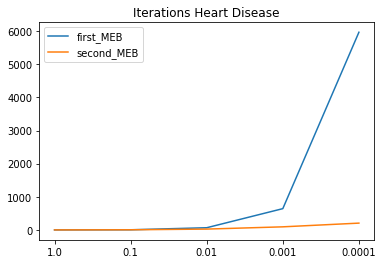

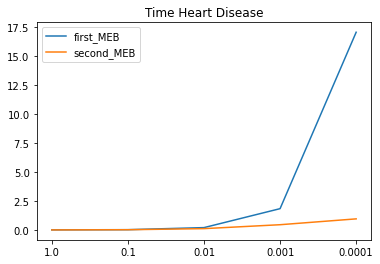

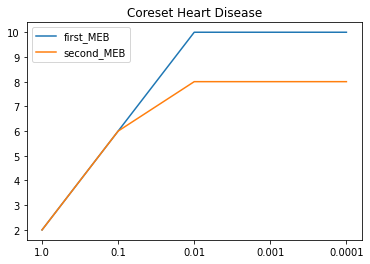

In [ ]:
'''
Heart Disease dataset First and Second MEB plots
'''

# range of epsilon values
eps_list = [round(0.1**i,i) for i in range(0,5)]

# First MEB algorithm
timer_first_heart = []
iterations_first_heart = []
coreset_first_heart = []

for epsilon in eps_list:
  t0_first = time.time()
  output_first_heart = first_MEB(data_heart,epsilon)
  iterations_first_heart.append(output_first_heart[-1])
  timer_first_heart.append(time.time()-t0_first)
  coreset_first_heart.append(sum([i != 0 for i in output_first_heart[2]]))

# Second MEB algorithm
timer_second_heart = []
iterations_second_heart = []
coreset_second_heart = []

for epsilon in eps_list:
  t0_second = time.time()
  output_second_heart = second_MEB(data_heart,epsilon)
  iterations_second_heart.append(output_second_heart[-1])
  timer_second_heart.append(time.time()-t0_second)
  coreset_second_heart.append(sum([i != 0 for i in output_second_heart[2]]))

default_ticks = range(len(eps_list))

# Iterations Heart Disease plot
plt.plot(default_ticks, iterations_first_heart, iterations_second_heart)
plt.xticks(default_ticks, eps_list)
plt.title("Iterations Heart Disease")
plt.legend(['first_MEB','second_MEB'])
plt.show()

# Time Heart Disease plot
plt.plot(default_ticks, timer_first_heart, timer_second_heart)
plt.xticks(default_ticks, eps_list)
plt.title("Time Heart Disease")
plt.legend(['first_MEB','second_MEB'])
plt.show()

# Coreset Heart Disease plot
plt.plot(default_ticks, coreset_first_heart, coreset_second_heart)
plt.xticks(default_ticks, eps_list)
plt.title("Coreset Heart Disease")
plt.legend(['first_MEB','second_MEB'])
plt.show()

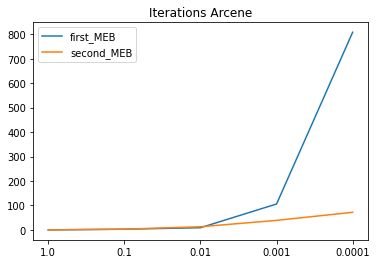

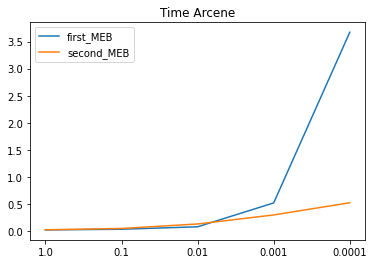

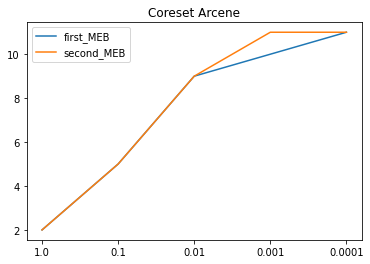

In [ ]:
'''
Arcene dataset First and Second MEB plots
'''

# range of epsilon values
eps_list = [round(0.1**i,i) for i in range(0,5)]

# First MEB algorithm
timer_first_arcene = []
iterations_first_arcene = []
coreset_first_arcene = []

for epsilon in eps_list:
  t0_first = time.time()
  output_first_arcene = first_MEB(data_arcene,epsilon)
  iterations_first_arcene.append(output_first_arcene[-1])
  timer_first_arcene.append(time.time()-t0_first)
  coreset_first_arcene.append(sum([i != 0 for i in output_first_arcene[2]]))

# Second MEB algorithm
timer_second_arcene = []
iterations_second_arcene = []
coreset_second_arcene = []

for epsilon in eps_list:
  t0_second = time.time()
  output_second_arcene = second_MEB(data_arcene,epsilon)
  iterations_second_arcene.append(output_second_arcene[-1])
  timer_second_arcene.append(time.time()-t0_second)
  coreset_second_arcene.append(sum([i != 0 for i in output_second_arcene[2]]))

default_ticks = range(len(eps_list))

# Iterations Arcene plot
plt.plot(default_ticks, iterations_first_arcene, iterations_second_arcene)
plt.xticks(default_ticks, eps_list)
plt.title("Iterations Arcene")
plt.legend(['first_MEB','second_MEB'])
plt.show()

# Time Arcene plot
plt.plot(default_ticks, timer_first_arcene, timer_second_arcene)
plt.xticks(default_ticks, eps_list)
plt.title("Time Arcene")
plt.legend(['first_MEB','second_MEB'])
plt.show()

# Coreset Arcene plot
plt.plot(default_ticks, coreset_first_arcene, coreset_second_arcene)
plt.xticks(default_ticks, eps_list)
plt.title("Coreset Arcene")
plt.legend(['first_MEB','second_MEB'])
plt.show()

#Anomaly detection

In [ ]:
'''
Anomaly detection of Heart Disease dataset with at least n heart attack (second_MEB)
'''
n = 1    # n from 0 to 4
c, Chi, u, r_annulus, r, iterations = second_MEB(data_heart[[x>=n for x in label_heart]], 0.001)

label_or = label_heart[[np.linalg.norm(c-row)>r for row in data_heart]]
print(f'Label of intances out of the radius: \n {label_or}, \n Cardinality: {len(label_or)} \n')
label_or_annulus = label_heart[[np.linalg.norm(c-row)>r_annulus for row in data_heart]]
print(f'Label of intances out of the radius + annulus: \n {label_or_annulus}, \n Cardinality: {len(label_or_annulus)} \n')
all_instances = label_heart[[x>=n for x in label_heart]]
print(f'All intances considered: \n {all_instances}, \n Cardinality: {len(all_instances)} \n')

Label of intances out of the radius: 
 [0. 3. 2. 1. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
 Cardinality: 19 

Label of intances out of the radius + annulus: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
 Cardinality: 15 

All intances considered: 
 [1. 3. 1. 3. 3. 1. 1. 1. 3. 3. 1. 3. 1. 4. 3. 1. 2. 4. 1. 1. 3. 1. 3. 1.
 2. 2. 2. 1. 1. 2. 3. 2. 2. 2. 4. 2. 1. 2. 1. 1. 1. 1. 3. 4. 1. 3. 3. 1.
 1. 4. 4. 4. 3. 2. 4. 3. 3. 4. 3. 4. 4. 4. 3. 1. 3. 2. 3. 2. 1. 1. 1. 1.
 1. 2. 2. 1. 1. 1. 4. 2. 2. 2. 3. 1. 2. 2. 2. 3. 4. 1. 3. 2. 1. 3. 2. 1.
 3. 4.], 
 Cardinality: 98 



In [ ]:
'''
Anomaly detection of Heart Disease dataset with at least n heart attack (first_MEB)
'''
n = 1    # n from 0 to 4
c, Chi, u, r_annulus, r, iterations = first_MEB(data_heart[[x>=n for x in label_heart]], 0.001)

label_or = label_heart[[np.linalg.norm(c-row)>r for row in data_heart]]
print(f'Label of intances out of the radius: \n {label_or}, \n Cardinality: {len(label_or)} \n')
label_or_annulus = label_heart[[np.linalg.norm(c-row)>r_annulus for row in data_heart]]
print(f'Label of intances out of the radius + annulus: \n {label_or_annulus}, \n Cardinality: {len(label_or_annulus)} \n')
all_instances = label_heart[[x>=n for x in label_heart]]
print(f'All intances considered: \n {all_instances}, \n Cardinality: {len(all_instances)} \n')

Label of intances out of the radius: 
 [0. 3. 2. 0. 1. 4. 0. 0. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
 Cardinality: 21 

Label of intances out of the radius + annulus: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
 Cardinality: 15 

All intances considered: 
 [1. 3. 1. 3. 3. 1. 1. 1. 3. 3. 1. 3. 1. 4. 3. 1. 2. 4. 1. 1. 3. 1. 3. 1.
 2. 2. 2. 1. 1. 2. 3. 2. 2. 2. 4. 2. 1. 2. 1. 1. 1. 1. 3. 4. 1. 3. 3. 1.
 1. 4. 4. 4. 3. 2. 4. 3. 3. 4. 3. 4. 4. 4. 3. 1. 3. 2. 3. 2. 1. 1. 1. 1.
 1. 2. 2. 1. 1. 1. 4. 2. 2. 2. 3. 1. 2. 2. 2. 3. 4. 1. 3. 2. 1. 3. 2. 1.
 3. 4.], 
 Cardinality: 98 



In [ ]:
'''
Anomaly detection of Arcene dataset with cancer or not (second_MEB)
'''
n = -1    # 1 positive, -1 negative
c, Chi, u, r_annulus, r, iterations = second_MEB(data_arcene[[x==n for x in label_arcene]], 0.0001)

label_or = label_arcene[[np.linalg.norm(c-row)>r for row in data_arcene]]
print(f'Label of intances out of the radius: \n {label_or}, \n Cardinality: {len(label_or)} \n')
label_or_annulus = label_arcene[[np.linalg.norm(c-row)>r_annulus for row in data_arcene]]
print(f'Label of intances out of the radius + annulus: \n {label_or_annulus}, \n Cardinality: {len(label_or_annulus)} \n')
all_instances = label_arcene[[x==n for x in label_arcene]]
print(f'All intances considered: \n {all_instances}, \n Cardinality: {len(all_instances)} \n')

Label of intances out of the radius: 
 [-1  1  1 -1 -1  1 -1 -1], 
 Cardinality: 8 

Label of intances out of the radius + annulus: 
 [1 1 1], 
 Cardinality: 3 

All intances considered: 
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1], 
 Cardinality: 56 



In [ ]:
'''
Anomaly detection of Arcene dataset with cancer or not (first_MEB)
'''
n = -1    # 1 positive, -1 negative
c, Chi, u, r_annulus, r, iterations = first_MEB(data_arcene[[x==n for x in label_arcene]], 0.0001)

label_or = label_arcene[[np.linalg.norm(c-row)>r for row in data_arcene]]
print(f'Label of intances out of the radius: \n {label_or}, \n Cardinality: {len(label_or)} \n')
label_or_annulus = label_arcene[[np.linalg.norm(c-row)>r_annulus for row in data_arcene]]
print(f'Label of intances out of the radius + annulus: \n {label_or_annulus}, \n Cardinality: {len(label_or_annulus)} \n')
all_instances = label_arcene[[x==n for x in label_arcene]]
print(f'All intances considered: \n {all_instances}, \n Cardinality: {len(all_instances)} \n')

Label of intances out of the radius: 
 [-1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1], 
 Cardinality: 15 

Label of intances out of the radius + annulus: 
 [1 1 1], 
 Cardinality: 3 

All intances considered: 
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1], 
 Cardinality: 56 

